In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.pipeline import make_pipeline
import os
import src.fitting as fitting
import src.multielec_utils as mutils
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

# Load in triplet stim elecResps and amplitudes

In [62]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity_cosine"

In [63]:
dataset = "2020-10-18-0"
estim = "data003/data003-all"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [64]:
wnoise = "kilosort_data000/data000"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [65]:
degree = 2
l2_reg = 0.01

In [89]:
p = 2
targets = np.array([12])
nontargets = np.array([11])

p_thr = 6/19
p_upper = 1
random_state = 0

In [90]:
def getWeights(p, n, degree, l2_reg=0.01):
    poly = PolynomialFeatures(degree)
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(amplitudes[:, 0][good_inds], 
                amplitudes[:, 1][good_inds],
                amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
#     ax.scatter(x.value[0], x.value[1], x.value[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

    clustering = SpectralClustering(n_clusters=2, 
                                    assign_labels='discretize',
                                    affinity='nearest_neighbors', 
                                    random_state=random_state).fit(X)

    cluster1 = np.where(clustering.labels_ == 0)[0]
    cluster2 = np.where(clustering.labels_ == 1)[0]

    X_pos = X[cluster1]
    X_neg = X[cluster2]

    y_pos = y[cluster1]
    y_neg = y[cluster2]

    OLS_X_neg = poly.fit_transform(X_neg)
    OLS_y_neg = np.log(y_neg / (1 - y_neg))

    OLS_w_neg = (np.linalg.inv(l2_reg * np.eye(OLS_X_neg.shape[-1]) + OLS_X_neg.T @ OLS_X_neg) @ OLS_X_neg.T) @ OLS_y_neg

    OLS_X_pos = poly.fit_transform(X_pos)
    OLS_y_pos = np.log(y_pos / (1 - y_pos))

    OLS_w_pos = (np.linalg.inv(l2_reg * np.eye(OLS_X_pos.shape[-1]) + OLS_X_pos.T @ OLS_X_pos) @ OLS_X_pos.T) @ OLS_y_pos

    return np.vstack((OLS_w_neg, OLS_w_pos))

OFF parasol


/tmp/ipykernel_49225/1619207558.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


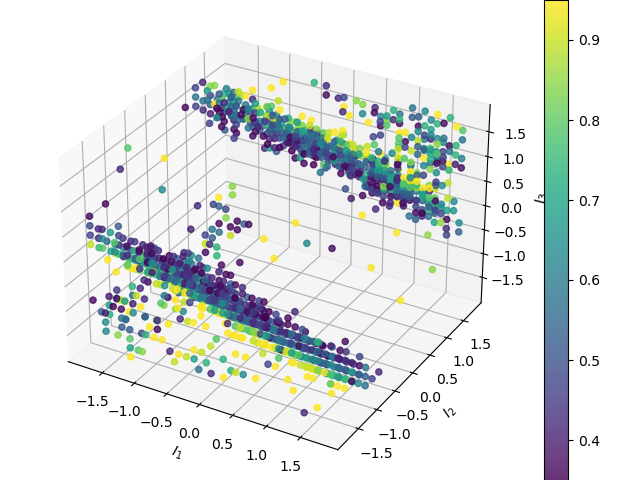

In [91]:
nt_weights = []
for nt in nontargets:
    print(vcd.get_cell_type_for_cell(nt))
    nt_weights.append(getWeights(p, nt, degree, l2_reg))

nt_weights = np.vstack((nt_weights))

In [92]:
nt_weights

array([[-0.54864652,  0.89861412,  0.23160628, -0.08876905, -0.06632255,
        -0.28351987, -0.37112425,  0.16159787,  0.18879276,  0.29330973],
       [-1.99072538, -1.93526922, -1.27648201, -0.82710549, -0.24947397,
        -0.86538119, -0.66605211,  0.02809048,  0.26182752,  0.17270263]])

ON parasol


/tmp/ipykernel_49225/1619207558.py:22: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


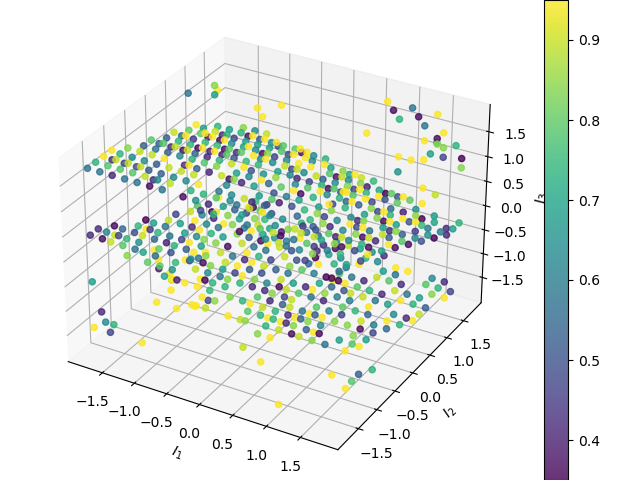

/Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [93]:
t_weights = []
for t in targets:
    print(vcd.get_cell_type_for_cell(t))
    t_weights.append(getWeights(p, t, degree, l2_reg))

t_weights = np.vstack((t_weights))

In [94]:
t_weights

array([[-7.26299988,  2.49234984,  5.25268741, 11.16082178, -0.01484512,
        -0.67681484, -1.32707028, -0.62217574, -3.16336108, -2.86888194],
       [-4.63549594, -2.02131448, -3.54695178, -9.19216617, -0.12029692,
        -0.49489327, -1.31379699, -0.24075717, -2.34193318, -2.87926275]])

In [95]:
def createPMatrixTriplet(weights):
    P = np.zeros((3,3))

    P[0][0] = weights[4] * 2
    P[1][1] = weights[7] * 2
    P[2][2] = weights[9] * 2

    P[0][1] = P[1][0] = weights[5]
    P[0][2] = P[2][0] = weights[6]
    P[1][2] = P[2][1] = weights[8]

    q = weights[1:4]

    return P, q

In [100]:
A, b = createPMatrixTriplet(nt_weights[1])

In [101]:
A, b

(array([[-0.49894793, -0.86538119, -0.66605211],
        [-0.86538119,  0.05618097,  0.26182752],
        [-0.66605211,  0.26182752,  0.34540527]]),
 array([-1.93526922, -1.27648201, -0.82710549]))

In [102]:
nt_weights[1]

array([-1.99072538, -1.93526922, -1.27648201, -0.82710549, -0.24947397,
       -0.86538119, -0.66605211,  0.02809048,  0.26182752,  0.17270263])

In [103]:
np.linalg.eig(A)

(array([-1.23603284,  1.16828227, -0.02961113]),
 array([[ 0.82516075,  0.54215864,  0.15866237],
        [ 0.49892123, -0.5677268 , -0.65480065],
        [ 0.26492896, -0.61947582,  0.73896032]]))

In [ ]:
I_max = 1.78125

T_t = cp.Variable(1)
T_n = cp.Variable(1)
x = cp.Variable(3)

constraints = [
    -t_weights[0, 0] - t_weights[0,1:] @ x  <= T_t,
    nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
    x <= I_max,
    -I_max <= x, 
]

objective_function = T_n + T_t + 0.5*cp.norm1(x)

objective = cp.Minimize(objective_function)
prob = cp.Problem(objective, constraints)
opt_val  = prob.solve()
print(f"Optimal value {opt_val}")

def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

print(f"optimal p_t {compute_pt(T_t.value)[0]}")
print(f"optimal p_n {compute_pn(T_n.value)[0]}")

In [ ]:
x.value